In [1]:

# https://github.com/pourya-ir/Medium/blob/master/Time%20Series%20Machine%20Learning%20Regression%20Framework.ipynb

# This notebook shows model including impact

# Model with parameters: model = SVR(kernel= 'rbf',C= 2.4,epsilon= .0348,shrinking=False,cache_size = 8000)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_log_error
from sklearn.svm import SVR

from sklearn import base

import warnings
warnings.filterwarnings('ignore')

# Data Prep

In [2]:
df_data = pd.read_csv('final_data.csv')
df_data = df_data.drop(columns=['Date'])
# TRDTYPE: 1 - Export, 2 - Import
# DISAGMOT: 1 - Truck, 2 - Air
# COUNTRY: 1 - Canada, 2 - Mexico
df_data_2_x_1_1 = df_data[(df_data['TRDTYPE'] == 2) & (df_data['DISAGMOT'] == 1) & (df_data['COUNTRY'] == 1)].copy()


df_data_2_x_1_1 = df_data_2_x_1_1.drop(columns=['TRDTYPE','DISAGMOT','COUNTRY','MONTH','YEAR'])
df_data_2_x_1_1 = df_data_2_x_1_1.reset_index().drop(columns= 'index')
df_data_2_x_1_1['VALUE'] = df_data_2_x_1_1['VALUE']/df_data_2_x_1_1['VALUE'].max()
df_data_2_x_1_1['impact'] = df_data_2_x_1_1['impact']/df_data_2_x_1_1['impact'].max()
df_data_2_x_1_1

,USASTATE,VALUE,impact,month_seq
0,2,0.005562,0.003012,0
1,1,0.024734,0.000659,0
2,5,0.019671,0.014509,0
3,4,0.015062,0.009298,0
4,6,0.217410,0.006904,0
...,...,...,...,...
5860,50,0.032248,0.000000,114
5861,53,0.138618,0.000003,114
5862,55,0.071326,0.000000,114
5863,54,0.020216,0.000000,114


In [3]:
df_data.head()

,TRDTYPE,USASTATE,DISAGMOT,COUNTRY,MONTH,YEAR,VALUE,impact,month_seq
0,1,2,2,1,6,2010,218276,1851.0,0
1,1,2,1,1,6,2010,17127165,1851.0,0
2,2,2,2,1,6,2010,2468944,1851.0,0
3,2,2,1,1,6,2010,16985164,1851.0,0
4,1,2,2,2,6,2010,11003,1851.0,0


In [4]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46749 entries, 0 to 46748
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TRDTYPE    46749 non-null  int64  
 1   USASTATE   46749 non-null  int64  
 2   DISAGMOT   46749 non-null  int64  
 3   COUNTRY    46749 non-null  int64  
 4   MONTH      46749 non-null  int64  
 5   YEAR       46749 non-null  int64  
 6   VALUE      46749 non-null  int64  
 7   impact     46749 non-null  float64
 8   month_seq  46749 non-null  int64  
dtypes: float64(1), int64(8)
memory usage: 3.2 MB


# To Supervised

In [5]:
class ToSupervised(base.BaseEstimator,base.TransformerMixin):
    
    def __init__(self,col,groupCol,numLags,dropna=False):
        
        self.col = col
        self.groupCol = groupCol
        self.numLags = numLags
        self.dropna = dropna
        
    def fit(self,X,y=None):
        self.X = X
        return self
    
    def transform(self,X):
        tmp = self.X.copy()
        for i in range(1,self.numLags+1):
            tmp[str(i)+'_prev_months'+"_"+self.col] = tmp.groupby([self.groupCol])[self.col].shift(i) 
            
        if self.dropna:
            tmp = tmp.dropna()
            tmp = tmp.reset_index(drop=True)
            
        return tmp

In [6]:
class ToSupervisedDiff(base.BaseEstimator,base.TransformerMixin):
    
    def __init__(self,col,groupCol,numLags,dropna=False):
        
        self.col = col
        self.groupCol = groupCol
        self.numLags = numLags
        self.dropna = dropna
        
    def fit(self,X,y=None):
        self.X = X
        return self
    
    def transform(self,X):
        tmp = self.X.copy()
        for i in range(1,self.numLags+1):
            tmp[str(i)+'_prev_months_diff_'+"_"+self.col] = tmp.groupby([self.groupCol])[self.col].diff(i) 
            
        if self.dropna:
            tmp = tmp.dropna()
            tmp = tmp.reset_index(drop=True)
            
        return tmp

# Time Series K-Fold

In [7]:
from itertools import chain
class Kfold_time(object):
    
    def __init__(self,**options):
        
        
        self.target     = options.pop('target', None)
        self.date_col   = options.pop('date_col', None)
        self.date_init  = options.pop('date_init', None)
        self.date_final = options.pop('date_final', None)

        if options:
            raise TypeError("Invalid parameters passed: %s" % str(options))
            
        if ((self.target==None )| (self.date_col==None )| (self.date_init==None ) | (self.date_final==None )):
            raise TypeError("Incomplete inputs")
    
    def _train_test_split_time(self,X):
        n_arrays = len(X)
        if n_arrays == 0:
            raise ValueError("At least one array required as input")

        for i in range(self.date_init,self.date_final):

            train = X[X[self.date_col] < i]
            val   = X[X[self.date_col] == i]

            X_train, X_test = train.drop([self.target], axis=1), val.drop([self.target], axis=1)
            y_train, y_test = train[self.target].values, val[self.target].values

            yield X_train, X_test, y_train, y_test

    
    def split(self,X):
        cv_t = self._train_test_split_time(X)
        return chain(cv_t)

# Metric: RMSLE

In [8]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

# Baseline Estimator

In [9]:
class BaseEstimator(base.BaseEstimator, base.RegressorMixin):
    def __init__(self, predCol):
        """
            As a base model we assume the VALUE last month and this month are the same
            Input: 
                    predCol: l-month ago VALUE
        """
        self.predCol = predCol

        
    def fit(self, X, y):
        return self


    def predict(self, X):
        prediction = X[self.predCol].values
        return prediction

    def score(self, X, y,scoring):
        
        prediction = self.predict(X)
    
        error =scoring(y, prediction)# np.sqrt(mean_squared_log_error(y, prediction))
        return error 

# Time Series Regression

In [10]:
class TimeSeriesRegressor(base.BaseEstimator, base.RegressorMixin):
    
    def __init__(self,model,cv,scoring,verbosity=True):
        self.model = model
        self.cv = cv
        self.verbosity = verbosity
        self.scoring = scoring 
        
            
    def fit(self,X,y=None):
        return self
        
    
    def predict(self,X=None):
        
        pred = {}
        for indx,fold in enumerate(self.cv.split(X)):

            X_train, X_test, y_train, y_test = fold    
            self.model.fit(X_train, y_train)
            pred[str(indx)+'_fold'] = self.model.predict(X_test)
            
        prediction = pd.DataFrame(pred)
    
        return prediction
    

    def score(self,X,y=None):


        errors = []
        for indx,fold in enumerate(self.cv.split(X)):

            X_train, X_test, y_train, y_test = fold    
            self.model.fit(X_train, y_train)
            prediction = self.model.predict(X_test)
            error = self.scoring(y_test, prediction)
            errors.append(error)

            if self.verbosity:
                print("Fold: {}, Error: {:.4f}".format(indx,error))

        if self.verbosity:
            print('Total Error {:.4f}'.format(np.mean(errors)))

        return errors

In [11]:
class TimeSeriesRegressorLog(base.BaseEstimator, base.RegressorMixin):
    
    def __init__(self,model,cv,scoring,verbosity=True):
        self.model = model
        self.cv = cv
        self.verbosity = verbosity
        self.scoring = scoring
        
            
    def fit(self,X,y=None):
        return self
        
    
    def predict(self,X=None):
        
        pred = {}
        for indx,fold in enumerate(self.cv.split(X)):

            X_train, X_test, y_train, y_test = fold    
            self.model.fit(X_train, y_train)
            pred[str(indx)+'_fold'] = self.model.predict(X_test)
            
        prediction = pd.DataFrame(pred)
    
        return prediction

    
    def score(self,X,y=None):#**options):


        errors = []
        for indx,fold in enumerate(self.cv.split(X)):

            X_train, X_test, y_train, y_test = fold    
            self.model.fit(X_train, np.log1p(y_train))
            prediction = np.expm1(self.model.predict(X_test))
            error = self.scoring(y_test, prediction)
            errors.append(error)

            if self.verbosity:
                print("Fold: {}, Error: {:.4f}".format(indx,error))

        if self.verbosity:
                print('Total Error {:.4f}'.format(np.mean(errors)))

        return errors

# Steps Tuning

In [12]:
def getDataFramePipeline(i):
    steps = [(str(i)+'_step_1',ToSupervised('VALUE','USASTATE',i)),
             (str(i)+'_step_2',ToSupervised('impact','USASTATE',i))]
    for j in range(1,i+1):
        if i==j:

            pp1 = (str(j)+'_step_diff_1',
                  ToSupervisedDiff(str(i)+'_prev_months_VALUE','USASTATE',1,dropna=True))
            steps.append(pp1)
            pp2 = (str(j)+'_step_diff_2',
                  ToSupervisedDiff(str(i)+'_prev_months_impact','USASTATE',1,dropna=True))
            steps.append(pp2)
        else:

            pp1 = (str(j)+'_step_diff_1',
                  ToSupervisedDiff(str(i)+'_prev_months_VALUE','USASTATE',1))
            steps.append(pp1)
            pp2 = (str(j)+'_step_diff_2',
                  ToSupervisedDiff(str(i)+'_prev_months_impact','USASTATE',1))
            steps.append(pp2)
            
    return steps

In [13]:
from tqdm import tqdm
def stepsTune(X,model,num_steps,init=1):
    scores = []
    for i in tqdm(range(init,num_steps+1)):
        steps = []
        steps.extend(getDataFramePipeline(i))
        steps.append(('predic_1',model))
        super_ = Pipeline(steps).fit(X)
        score_ = np.mean(super_.score(X))
        scores.append((i,score_))
        
    return scores

# Tune Hyperparameters

In [14]:
from collections.abc import Mapping, Sequence, Iterable
from itertools import product
from functools import partial, reduce
import operator

class TimeGridBasic(base.BaseEstimator, base.RegressorMixin):
    
    def __init__(self,param_grid):
        
    
        if not isinstance(param_grid, (Mapping, Iterable)):
                raise TypeError('Parameter grid is not a dict or '
                                'a list ({!r})'.format(param_grid))

        if isinstance(param_grid, Mapping):
                # wrap dictionary in a singleton list to support either dict
                # or list of dicts
                param_grid = [param_grid]


        if isinstance(param_grid, Mapping):
                # wrap dictionary in a singleton list to support either dict
                # or list of dicts
                param_grid = [param_grid]

        # check if all entries are dictionaries of lists
        for grid in param_grid:
            if not isinstance(grid, dict):
                raise TypeError('Parameter grid is not a '
                                'dict ({!r})'.format(grid))
            for key in grid:
                if not isinstance(grid[key], Iterable):
                    raise TypeError('Parameter grid value is not iterable '
                                    '(key={!r}, value={!r})'
                                    .format(key, grid[key]))


        self.param_grid = param_grid
                
    def __iter__(self):
        """Iterate over the points in the grid.
        Returns
        -------
        params : iterator over dict of string to any
            Yields dictionaries mapping each estimator parameter to one of its
            allowed values.
        """
        for p in self.param_grid:
            # Always sort the keys of a dictionary, for reproducibility
            items = sorted(p.items())
            if not items:
                yield {}
            else:
                keys, values = zip(*items)
                for v in product(*values):
                    params = dict(zip(keys, v))
                    yield params

In [15]:
class TimeSeriesGridSearch(TimeGridBasic,base.BaseEstimator, base.RegressorMixin):
    
    
    def __init__(self,**options):
        
        self.model      = options.pop('model', None)
        self.cv         = options.pop('cv', None)
        self.verbosity  = options.pop('verbosity', False)
        self.scoring    = options.pop('scoring', None)
        param_grid      = options.pop('param_grid', None)
        self.param_grid = TimeGridBasic(param_grid)
        
        if options:
            raise TypeError("Invalid parameters passed: %s" % str(options))

        if ((self.model==None )| (self.cv==None)):
            raise TypeError("Incomplete inputs")
            
            
    def fit(self,X,y=None):
        self.X = X
        return self


    def _get_score(self,param):

        errors = []
        for indx,fold in enumerate(self.cv.split(self.X)):

            X_train, X_test, y_train, y_test = fold    
            self.model.set_params(**param).fit(X_train, np.log1p(y_train))
            prediction = np.expm1(self.model.predict(X_test))
            error = self.scoring(y_test, prediction)
            errors.append(error)

            if self.verbosity:
                print("Fold: {}, Error: {:.4f}".format(indx,error))

        if self.verbosity:
                print('Total Error {:.4f}'.format(np.mean(errors)))
                
        
        return errors

    def score(self):

        errors=[]
        get_param = []
        for param in self.param_grid:
            
            if self.verbosity:
                print(param)
                
            errors.append(np.mean(self._get_score(param)))
            get_param.append(param)

        self.sorted_errors,self.sorted_params = (list(t) for t in zip(*sorted(zip(errors,get_param))))
        
        return self.sorted_errors,self.sorted_params
    
    
    def best_estimator(self,verbosity=False):

        if verbosity:
            print('error: {:.4f} \n'.format(self.sorted_errors[0]))
            print('Best params:')
            print(self.sorted_params[0])

        return self.sorted_params[0]

# State VALUE Distribution

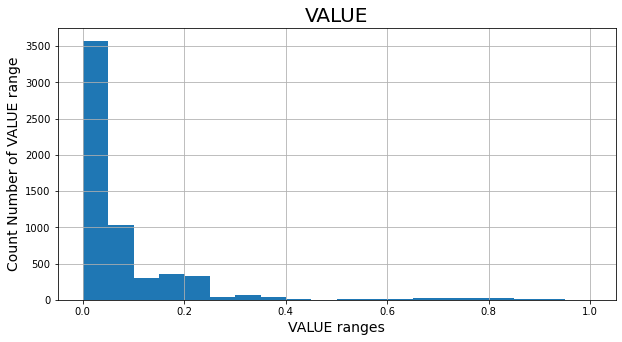

In [16]:
df_data_2_x_1_1['VALUE'].hist(bins=20, figsize=(10,5))
plt.xlabel('VALUE ranges',fontsize=14)
plt.ylabel('Count Number of VALUE range',fontsize=14)
plt.title('VALUE',fontsize=20)
plt.show()

# Data Prep

In [17]:
steps = [('1_step_1',ToSupervised('VALUE','USASTATE',1)),
         ('1_step_2',ToSupervised('impact','USASTATE',1)),
         ('1_step_diff_1',ToSupervisedDiff('1_prev_months_VALUE','USASTATE',1,dropna=True)),
         ('1_step_diff_2',ToSupervisedDiff('1_prev_months_impact','USASTATE',1,dropna=True))]
super_1 = Pipeline(steps).fit_transform(df_data_2_x_1_1)
super_1.head()

,USASTATE,VALUE,impact,month_seq,1_prev_months_VALUE,1_prev_months_impact,1_prev_months_diff__1_prev_months_VALUE,1_prev_months_diff__1_prev_months_impact
0,2,0.006982,0.000049,3,0.007090,0.001066,0.000062,0.000630
1,1,0.028797,0.004502,3,0.029417,0.000509,-0.000306,-0.004127
2,5,0.012663,0.013780,3,0.013561,0.013352,-0.005679,0.009438
3,4,0.017482,0.002070,3,0.013500,0.001129,-0.000881,0.000568
4,6,0.173340,0.034575,3,0.252416,0.161551,0.083098,0.150125


# First Model - One Step

In [18]:
kf = Kfold_time(target='VALUE',date_col = 'month_seq',date_init=50,date_final=75)
model = SVR(kernel= 'rbf',C= 2.7,epsilon= .0348,shrinking=False,cache_size = 8000)

In [19]:
steps_1 = [('1_step_1',ToSupervised('VALUE','USASTATE',1)),
           ('1_step_2',ToSupervised('impact','USASTATE',1)),
         ('1_step_diff_1',ToSupervisedDiff('1_prev_months_VALUE','USASTATE',1,dropna=True)),
           ('1_step_diff_2',ToSupervisedDiff('1_prev_months_impact','USASTATE',1,dropna=True)),
         ('predic_1',TimeSeriesRegressor(model=model,cv=kf,scoring=rmsle))]
super_1_p = Pipeline(steps_1).fit(df_data_2_x_1_1)

In [20]:
Model_1_Error = super_1_p.score(df_data_2_x_1_1)

Fold: 0, Error: 0.0660
Fold: 1, Error: 0.0760
Fold: 2, Error: 0.0751
Fold: 3, Error: 0.0667
Fold: 4, Error: 0.0701
Fold: 5, Error: 0.0644
Fold: 6, Error: 0.0623
Fold: 7, Error: 0.0749
Fold: 8, Error: 0.0672
Fold: 9, Error: 0.0656
Fold: 10, Error: 0.0860
Fold: 11, Error: 0.0664
Fold: 12, Error: 0.0721
Fold: 13, Error: 0.0742
Fold: 14, Error: 0.0787
Fold: 15, Error: 0.0718
Fold: 16, Error: 0.0701
Fold: 17, Error: 0.0730
Fold: 18, Error: 0.0769
Fold: 19, Error: 0.0814
Fold: 20, Error: 0.0741
Fold: 21, Error: 0.0784
Fold: 22, Error: 0.0826
Fold: 23, Error: 0.0621
Fold: 24, Error: 0.0823
Total Error 0.0727


# Second Model - Four Steps

In [21]:
steps_3 = [('1_step_1',ToSupervised('VALUE','USASTATE',3)),
           ('1_step_2',ToSupervised('impact','USASTATE',3)),
         ('1_step_diff',ToSupervisedDiff('1_prev_months_VALUE','USASTATE',1)),
         ('2_step_diff',ToSupervisedDiff('2_prev_months_VALUE','USASTATE',1)),
         ('3_step_diff',ToSupervisedDiff('3_prev_months_VALUE','USASTATE',1,dropna=True)),
           ('1_step_diff_2',ToSupervisedDiff('1_prev_months_impact','USASTATE',1)),
         ('2_step_diff_2',ToSupervisedDiff('2_prev_months_impact','USASTATE',1)),
         ('3_step_diff_3',ToSupervisedDiff('3_prev_months_impact','USASTATE',1,dropna=True)),
         ('predic_3',TimeSeriesRegressor(model=model,cv=kf,scoring=rmsle))]
super_3_p = Pipeline(steps_3).fit(df_data_2_x_1_1)

In [22]:
Model_3_Error = super_3_p.score(df_data_2_x_1_1)

Fold: 0, Error: 0.0420
Fold: 1, Error: 0.0498
Fold: 2, Error: 0.0493
Fold: 3, Error: 0.0422
Fold: 4, Error: 0.0429
Fold: 5, Error: 0.0399
Fold: 6, Error: 0.0392
Fold: 7, Error: 0.0506
Fold: 8, Error: 0.0458
Fold: 9, Error: 0.0437
Fold: 10, Error: 0.0615
Fold: 11, Error: 0.0470
Fold: 12, Error: 0.0482
Fold: 13, Error: 0.0484
Fold: 14, Error: 0.0534
Fold: 15, Error: 0.0459
Fold: 16, Error: 0.0435
Fold: 17, Error: 0.0466
Fold: 18, Error: 0.0522
Fold: 19, Error: 0.0569
Fold: 20, Error: 0.0499
Fold: 21, Error: 0.0522
Fold: 22, Error: 0.0564
Fold: 23, Error: 0.0386
Fold: 24, Error: 0.0523
Total Error 0.0479


# Change Target Distribution

In [23]:
steps_3_log = [('1_step',ToSupervised('VALUE','USASTATE',3)),
         ('1_step_diff',ToSupervisedDiff('1_prev_months_VALUE','USASTATE',1)),
         ('2_step_diff',ToSupervisedDiff('2_prev_months_VALUE','USASTATE',1)),
         ('3_step_diff',ToSupervisedDiff('3_prev_months_VALUE','USASTATE',1,dropna=True)),
         ('predic_3',TimeSeriesRegressorLog(model=model,cv=kf,scoring=rmsle))]
super_3_p_log = Pipeline(steps_3_log).fit(df_data_2_x_1_1)

In [24]:
Model_3_Log_Error = super_3_p_log.score(df_data_2_x_1_1)

Fold: 0, Error: 0.0391
Fold: 1, Error: 0.0477
Fold: 2, Error: 0.0475
Fold: 3, Error: 0.0398
Fold: 4, Error: 0.0400
Fold: 5, Error: 0.0376
Fold: 6, Error: 0.0374
Fold: 7, Error: 0.0487
Fold: 8, Error: 0.0437
Fold: 9, Error: 0.0416
Fold: 10, Error: 0.0591
Fold: 11, Error: 0.0453
Fold: 12, Error: 0.0458
Fold: 13, Error: 0.0466
Fold: 14, Error: 0.0517
Fold: 15, Error: 0.0429
Fold: 16, Error: 0.0406
Fold: 17, Error: 0.0427
Fold: 18, Error: 0.0482
Fold: 19, Error: 0.0523
Fold: 20, Error: 0.0455
Fold: 21, Error: 0.0478
Fold: 22, Error: 0.0515
Fold: 23, Error: 0.0359
Fold: 24, Error: 0.0487
Total Error 0.0451


# Tuning Number of Steps

In [25]:
list_scores2 = stepsTune(df_data_2_x_1_1,
                         TimeSeriesRegressorLog(model=model,scoring=rmsle,
                                             cv=kf,verbosity=False),14)

100%|██████████| 14/14 [01:35<00:00,  6.81s/it]


Text(0.5, 1.0, 'Steps Tuning')

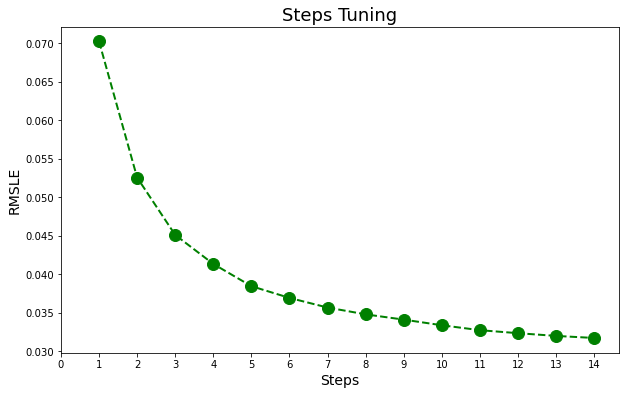

In [26]:
plt.figure(figsize=(10,6))
x = [i[0] for i in list_scores2]
y = [i[1] for i in list_scores2]
plt.plot(x,y,color='green', marker='o', linestyle='dashed',
        linewidth=2, markersize=12)
plt.xticks(np.arange(0, 15, step=1))
plt.xlabel('Steps',fontsize=14)
plt.ylabel('RMSLE',fontsize=14)
plt.title('Steps Tuning',fontsize=18)

# Prediction v Actual Value

In [27]:
kf_112_114 = Kfold_time(target='VALUE',date_col = 'month_seq',date_init=111,date_final=114)

steps_14 = getDataFramePipeline(14)
super_14 = Pipeline(steps_14).fit_transform(df_data_2_x_1_1)

In [28]:
from xgboost import XGBRegressor
model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=100, max_depth=4)
T_112_114 = TimeSeriesRegressorLog(model=model ,scoring=rmsle,
                                             cv=kf_112_114,verbosity=False)
T_112_114.fit(super_14)
prediction112_114 =T_112_114.predict(super_14)

In [29]:
prediction112_114.head()

,0_fold,1_fold,2_fold
0,0.006765,0.009611,0.009787
1,0.050924,0.064853,0.055682
2,0.017100,0.017295,0.018077
3,0.023818,0.027811,0.029056
4,0.242713,0.237634,0.215607


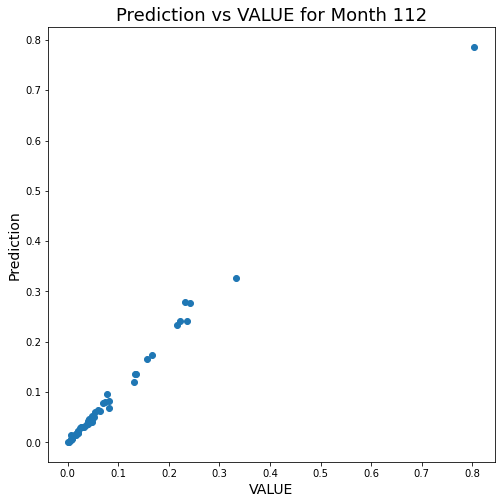

In [30]:
plt.figure(figsize=(8,8))
plt.scatter(prediction112_114['0_fold'],df_data_2_x_1_1[df_data_2_x_1_1['month_seq']==112]['VALUE'])
plt.xlabel('VALUE',fontsize=14)
plt.ylabel('Prediction',fontsize=14)

plt.title('Prediction vs VALUE for Month 112',fontsize=18)
plt.show()

In [31]:
x = 0
sum_diff = 0
for i in list(prediction112_114['0_fold']):
    sum_diff += abs(i-list(df_data_2_x_1_1[df_data_2_x_1_1['month_seq']==112]['VALUE'])[x])
    x+=1
mae = sum_diff/len(prediction112_114['0_fold'])
mae

0.0058859981678747505

In [32]:
x = 0
sum_diff_sq = 0
for i in list(prediction112_114['0_fold']):
    sum_diff_sq += (i-list(df_data_2_x_1_1[df_data_2_x_1_1['month_seq']==112]['VALUE'])[x])**2
    x+=1
rmse = (sum_diff_sq/len(prediction112_114['0_fold']))**.5
rmse

0.010380119658235269

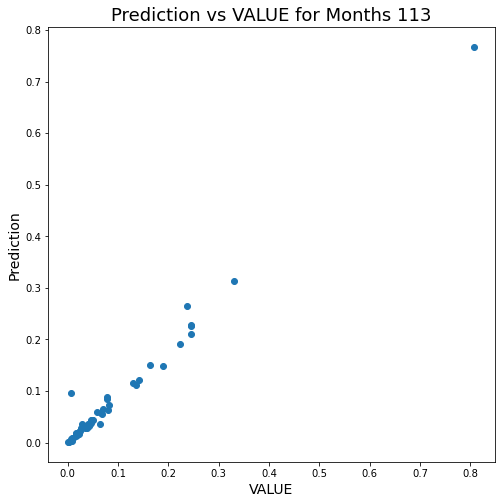

In [33]:
plt.figure(figsize=(8,8))
plt.scatter(prediction112_114['1_fold'],df_data_2_x_1_1[df_data_2_x_1_1['month_seq']==113]['VALUE'])
plt.xlabel('VALUE',fontsize=14)
plt.ylabel('Prediction',fontsize=14)

plt.title('Prediction vs VALUE for Months 113',fontsize=18)
plt.show()

In [34]:
x = 0
sum_diff = 0
for i in list(prediction112_114['1_fold']):
    sum_diff += abs(i-list(df_data_2_x_1_1[df_data_2_x_1_1['month_seq']==113]['VALUE'])[x])
    x+=1
mae = sum_diff/len(prediction112_114['1_fold'])
mae

0.011599398283217165

In [35]:
x = 0
sum_diff_sq = 0
for i in list(prediction112_114['1_fold']):
    sum_diff_sq += (i-list(df_data_2_x_1_1[df_data_2_x_1_1['month_seq']==113]['VALUE'])[x])**2
    x+=1
rmse = (sum_diff_sq/len(prediction112_114['1_fold']))**.5
rmse

0.019119958161653877

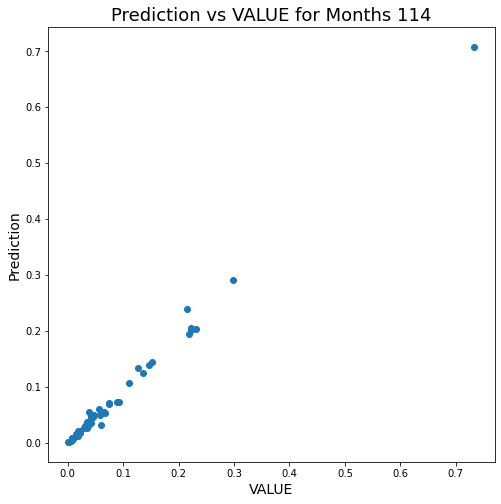

In [36]:
plt.figure(figsize=(8,8))
plt.scatter(prediction112_114['2_fold'],df_data_2_x_1_1[df_data_2_x_1_1['month_seq']==114]['VALUE'])
plt.xlabel('VALUE',fontsize=14)
plt.ylabel('Prediction',fontsize=14)

plt.title('Prediction vs VALUE for Months 114',fontsize=18)
plt.show()

In [37]:
x = 0
sum_diff = 0
for i in list(prediction112_114['2_fold']):
    sum_diff += abs(i-list(df_data_2_x_1_1[df_data_2_x_1_1['month_seq']==114]['VALUE'])[x])
    x+=1
mae = sum_diff/len(prediction112_114['2_fold'])
mae

0.007814364986388662

In [38]:
x = 0
sum_diff_sq = 0
for i in list(prediction112_114['2_fold']):
    sum_diff_sq += (i-list(df_data_2_x_1_1[df_data_2_x_1_1['month_seq']==114]['VALUE'])[x])**2
    x+=1
rmse = (sum_diff_sq/len(prediction112_114['2_fold']))**.5
rmse

0.011072561916753945